In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(argparser))) # command line arguments
suppressPackageStartupMessages(suppressWarnings(library(patchwork))) # plot patchwork
suppressPackageStartupMessages(suppressWarnings(library(reshape2))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggridges))) # ridgeline plots


source("../../figures/utils/figure_themes.r")


In [2]:
cell_type <- "PBMC"
model_name <- "MultiClass_MLP"

In [3]:
# set file path for importing the data
training_metrics_file <- file.path(paste0(
    "../../4.sc_Morphology_Neural_Network_MLP_Model/results/Multi_Class/",model_name,"/",cell_type,"/training_metrics.parquet"
))
confusion_matrix_file <- file.path(paste0(
    "../../4.sc_Morphology_Neural_Network_MLP_Model/results/Multi_Class/",model_name,"/",cell_type,"/confusion_matrices.parquet"
))
pr_curves_path <- file.path(paste0(
        "../../4.sc_Morphology_Neural_Network_MLP_Model/results/Multi_Class/",model_name,"/",cell_type,"/PR_curves.parquet"
))


# set output file path for graphs
f1_plot_path <- file.path(paste0(
    "figures/Multi_Class/",model_name,"/",cell_type,"/f1_score.png"
))

confusion_matrix_plot_path <- file.path(paste0(
    "figures/Multi_Class/",model_name,"/",cell_type,"/confusion_matrix.png"
))

# make the output directory if it doesn't exist
dir.create(file.path(paste0(
    "figures/Multi_Class/",model_name,"/",cell_type
)), showWarnings = FALSE, recursive = TRUE)



# read in the data
training_metrics <- arrow::read_parquet(training_metrics_file)
confusion_matrix <- arrow::read_parquet(confusion_matrix_file)
PR_curves <- arrow::read_parquet(pr_curves_path)


In [4]:

support <- training_metrics[training_metrics$metric == "support",]
# get apoptosis, healthy, and pyroptosis support rows in one df
support <- support[support$label %in% c("apoptosis", "healthy", "pyroptosis"),]


In [5]:
# get the rows that contain the F1 scores
f1_scores <- training_metrics[training_metrics$metric == "f1-score",]
# remove the rows that contain the macro and weighted averages
f1_scores <- f1_scores[!grepl("macro avg", f1_scores$label),]
f1_scores <- f1_scores[!grepl("weighted avg", f1_scores$label),]
# muatate the label column for multiple cases
f1_scores$label <- gsub("healthy", "Control", f1_scores$label)
f1_scores$label <- gsub("apoptosis", "Apoptosis", f1_scores$label)
f1_scores$label <- gsub("pyroptosis", "Pyroptosis", f1_scores$label)
# mutate the data type column
f1_scores$group <- gsub("train", "Training", f1_scores$group)
f1_scores$group <- gsub("test", "Testing", f1_scores$group)
f1_scores$group <- gsub("validation", "Validation", f1_scores$group)
f1_scores$group <- gsub("treatment_holdout", "Treatment Holdout", f1_scores$group)
f1_scores$group <- gsub("holdout", "Holdout", f1_scores$group)
# factorize the group column
f1_scores$group <- factor(f1_scores$group, levels = c(
    "Training", "Validation", "Testing","Treatment Holdout", "Holdout"
))
# mutate the shuffled_data column
f1_scores$shuffle <- gsub("TRUE", "Shuffled", f1_scores$shuffle)
f1_scores$shuffle <- gsub("FALSE", "Not Shuffled", f1_scores$shuffle)
# cbind the support column to the f1_scores df
f1_scores <- cbind(f1_scores, support$value)
# rename the support column
colnames(f1_scores)[colnames(f1_scores) == "support$value"] <- "support"
# dived the support by 10,000 to get the number of cells
f1_scores$support <- f1_scores$support / 10000
# round the support column to 2 decimal places
f1_scores$support <- round(f1_scores$support, 2)


In [6]:
# make the label a factor so that the order is preserved
f1_scores$label <- factor(
    f1_scores$label, levels = c(
        "Control", "Apoptosis", "Pyroptosis"
        )
    )


F1 score  
### $F1 Score = 2 * \frac{precision * recall}{precision + recall}$
### $Precision = \frac{TP}{TP + FP}$
### $Recall = \frac{TP}{TP + FN}$
### $F1 Score = \frac{2 * TP}{2 * TP + FP + FN}$

In [7]:
head(f1_scores, 1)

,label,metric,value,group,shuffle,support
,<fct>,<chr>,<dbl>,<fct>,<chr>,<dbl>
1,Apoptosis,f1-score,0,Training,Shuffled,9.59


In [8]:
# remove the treatment holdout rows
f1_scores <- f1_scores[!grepl("Treatment Holdout", f1_scores$group),]

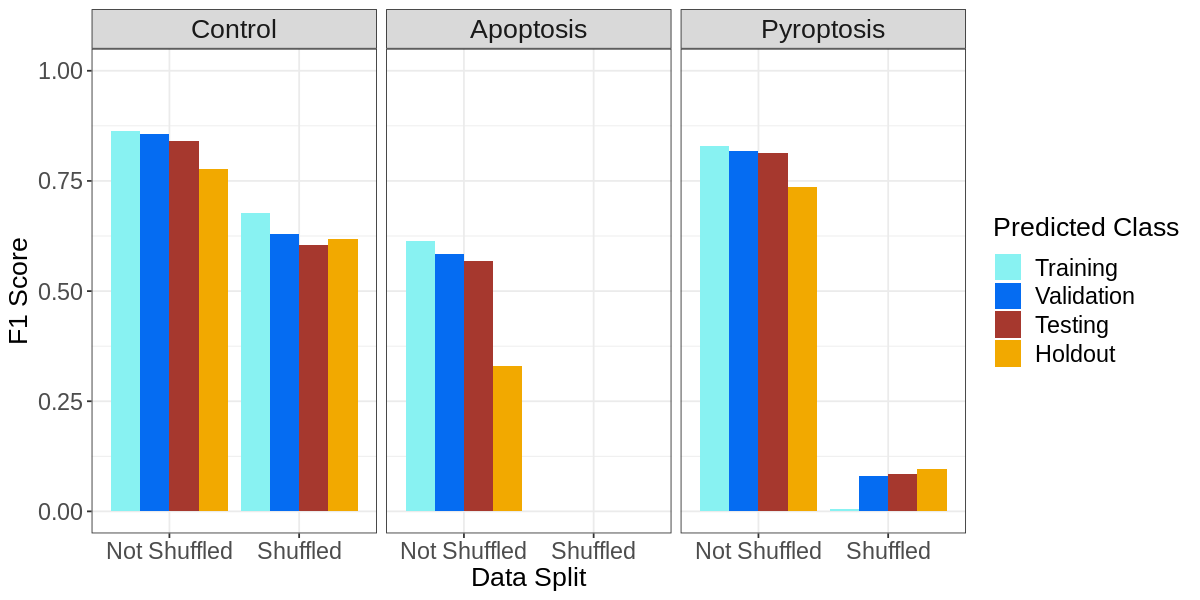

In [9]:
# set plot size
width <- 10
height <- 5
options(repr.plot.width = width, repr.plot.height = height)
# bar plot of the F1 scores
f1_score_plot <- (
    ggplot(f1_scores, aes(x = shuffle, y = value, fill = group))
    + geom_bar(stat = "identity", position = "dodge")

    + ylim(0, 1)
    + facet_wrap(~label)
    + ylab("F1 Score")
    + xlab("Data Split")
    # change the legend title
    + labs(fill = "Predicted Class")
    # change the colours
    + scale_fill_manual(values = c(
        "Training" = "#88F2F2",
        "Validation" = "#056CF2",
        "Testing" = "#A6382E",
        "Holdout" = "#F2A900"
    ))
    + figure_theme_wide

)
ggsave(f1_plot_path, f1_score_plot, width = width, height = height, dpi = 600)
f1_score_plot


## Confusion Matrix data plot

In [10]:
# round the Recall vlaues to 2 decimal places
confusion_matrix$Recall <- round(confusion_matrix$Recall, 2)
# mutate the label column for multiple cases
confusion_matrix$True_Label <- gsub("healthy", "Control", confusion_matrix$True_Label)
confusion_matrix$True_Label <- gsub("apoptosis", "Apoptosis", confusion_matrix$True_Label)
confusion_matrix$True_Label <- gsub("pyroptosis", "Pyroptosis", confusion_matrix$True_Label)
confusion_matrix$Predicted_Label <- gsub("healthy", "Control", confusion_matrix$Predicted_Label)
confusion_matrix$Predicted_Label <- gsub("apoptosis", "Apoptosis", confusion_matrix$Predicted_Label)
confusion_matrix$Predicted_Label <- gsub("pyroptosis", "Pyroptosis", confusion_matrix$Predicted_Label)

# make the True Label and Predicted Label columns factors
confusion_matrix$True_Label <- factor(
    confusion_matrix$True_Label, levels = c(
        "Control", "Apoptosis", "Pyroptosis"
        )
    )
confusion_matrix$Predicted_Label <- factor(
    confusion_matrix$Predicted_Label, levels = c(
       "Pyroptosis", "Apoptosis", "Control"
        )
    )
    

# mutate the shuffle column
confusion_matrix$shuffle <- gsub("TRUE", "Shuffled", confusion_matrix$shuffle)
confusion_matrix$shuffle <- gsub("FALSE", "Not Shuffled", confusion_matrix$shuffle)
# mutate the data type column
confusion_matrix$data_split <- gsub("testing", "Testing", confusion_matrix$data_split)
confusion_matrix$data_split <- gsub("holdout", "Hold Out Wells", confusion_matrix$data_split)
# make the data split column a factor
confusion_matrix$data_split <- factor(confusion_matrix$data_split, levels = c(
    "Testing", "Hold Out Wells"
))


In [11]:
head(confusion_matrix)

True_Label,Predicted_Label,Count,data_split,Recall,shuffle
<fct>,<fct>,<int>,<fct>,<dbl>,<chr>
Apoptosis,Control,884,Testing,0.00,Shuffled
Control,Control,789033,Testing,0.87,Shuffled
Pyroptosis,Control,113692,Testing,0.13,Shuffled
Apoptosis,Apoptosis,62,Testing,0.00,Shuffled
Control,Apoptosis,108037,Testing,0.90,Shuffled
Pyroptosis,Apoptosis,11812,Testing,0.10,Shuffled


In [12]:
# add the , to the count column
confusion_matrix$Count <- sapply(
    confusion_matrix$Count, function(x) format(x, big.mark = ",")
    )

head(confusion_matrix)

True_Label,Predicted_Label,Count,data_split,Recall,shuffle
<fct>,<fct>,<chr>,<fct>,<dbl>,<chr>
Apoptosis,Control,884,Testing,0.00,Shuffled
Control,Control,"789,033",Testing,0.87,Shuffled
Pyroptosis,Control,"113,692",Testing,0.13,Shuffled
Apoptosis,Apoptosis,62,Testing,0.00,Shuffled
Control,Apoptosis,"108,037",Testing,0.90,Shuffled
Pyroptosis,Apoptosis,"11,812",Testing,0.10,Shuffled


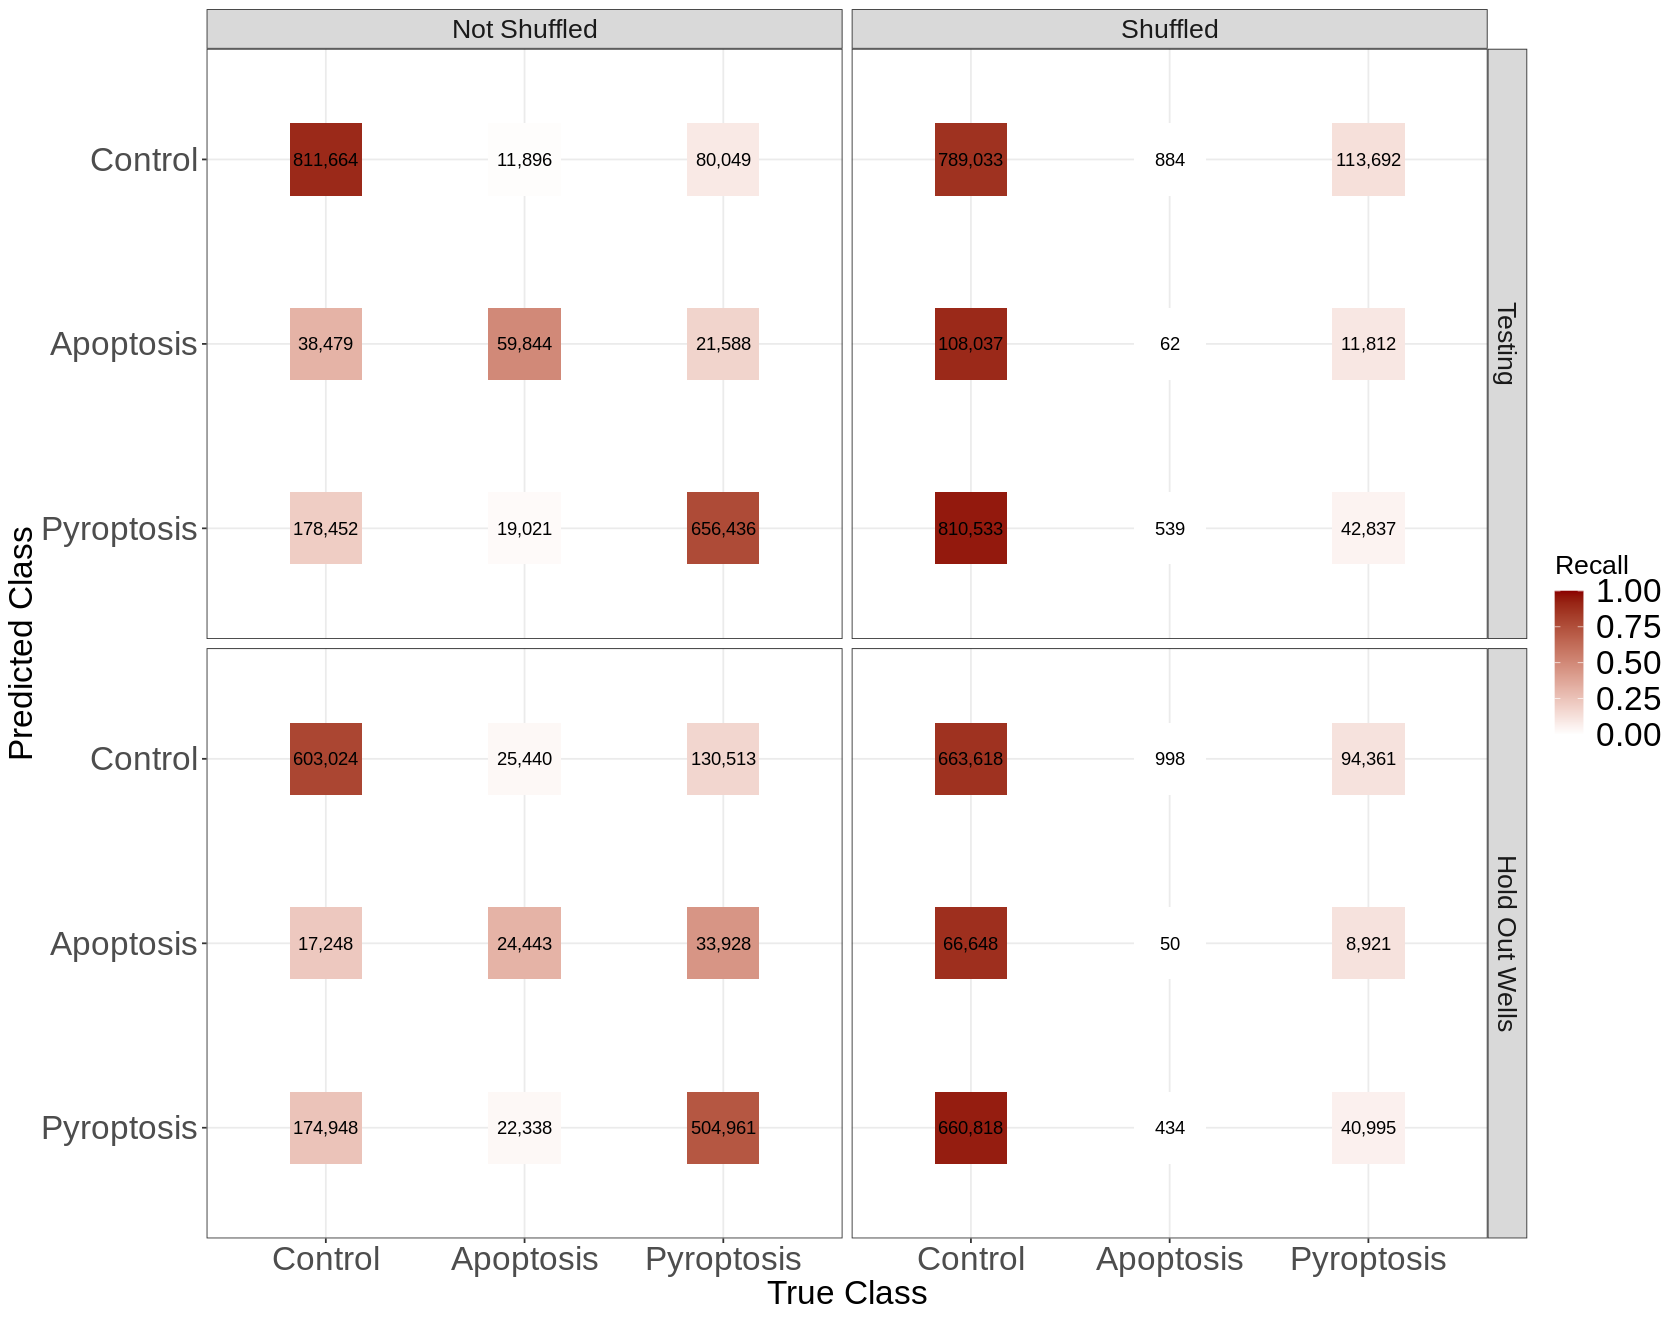

In [ ]:
# plot dimensions
width <- 14
height <- 11
options(repr.plot.width = width, repr.plot.height = height)
# plot a confusion matrix
confusion_matrix_plot <- (
    ggplot(confusion_matrix, aes(x = True_Label, y = Predicted_Label))
    + facet_grid(data_split~shuffle)
    + geom_point(aes(color = Recall), size = 20, shape = 15)
    + geom_text(aes(label = Count))
    + scale_color_gradient("Recall", low = "dark red", high = "blue",limits = c(0, 1))
    + theme_bw()
    + ylab("Predicted Class")
    + xlab("True Class")
    + figure_theme


)
ggsave(confusion_matrix_plot_path, confusion_matrix_plot, width = width, height = height, dpi = 600)
confusion_matrix_plot


## PR Curves

In [14]:
# replace strings in pr_curves
PR_curves$label <- gsub("apoptosis", "Apoptosis", PR_curves$label)
PR_curves$label <- gsub("healthy", "Control", PR_curves$label)
PR_curves$label <- gsub("pyroptosis", "Pyroptosis", PR_curves$label)

PR_curves$data_split <- gsub("train", "Training", PR_curves$data_split)
PR_curves$data_split <- gsub("testing", "Testing", PR_curves$data_split)
PR_curves$data_split <- gsub("validation", "Validation", PR_curves$data_split)
PR_curves$data_split <- gsub("treatment_holdout", "Treatment Holdout", PR_curves$data_split)
PR_curves$data_split <- gsub("holdout", "Holdout", PR_curves$data_split)

# factorize the data_split column
PR_curves$data_split <- factor(PR_curves$data_split, levels = c(
    "Training", "Validation", "Testing","Treatment Holdout", "Holdout"
))

unique(PR_curves$label)
unique(PR_curves$data_split)

# replace strings in pr_curves shuffle
PR_curves$shuffle <- gsub("TRUE", "Shuffled", PR_curves$shuffle)
PR_curves$shuffle <- gsub("FALSE", "Not Shuffled", PR_curves$shuffle)

# factorize the shuffled_data column
PR_curves$shuffle <- factor(PR_curves$shuffle, levels = c(
    "Not Shuffled", "Shuffled"
))
# class label factor
PR_curves$label <- factor(
    PR_curves$label, levels = c(
        "Control", "Apoptosis", "Pyroptosis"
        )
    )
    
# remove the treatment holdout rows
PR_curves <- PR_curves[!grepl("Treatment Holdout", PR_curves$data_split),]


[1] "Apoptosis"  "Control"    "Pyroptosis"

[1] Training          Validation        Testing           Treatment Holdout
[5] Holdout          
Levels: Training Validation Testing Treatment Holdout Holdout

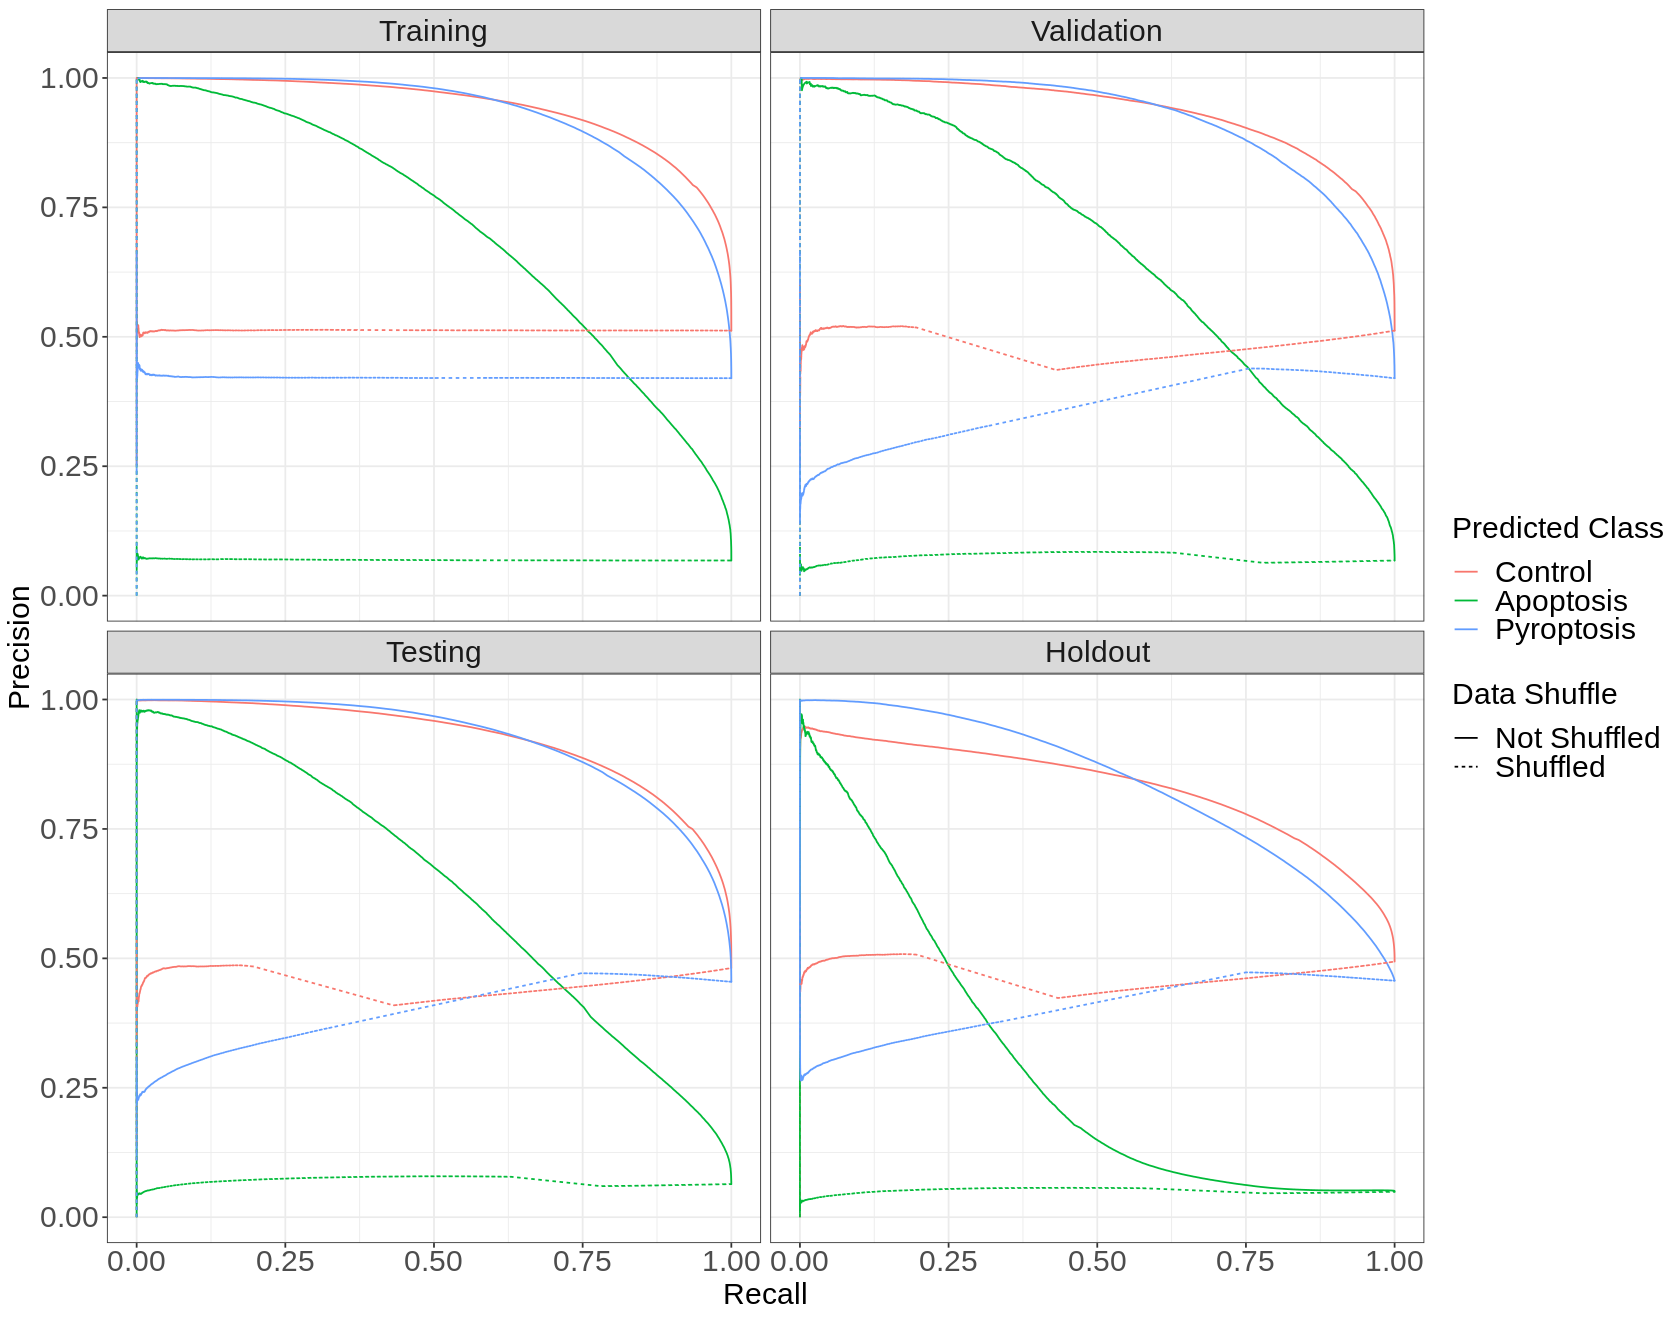

In [15]:
# make a line plot that has the shuffled and not shuffled lines
# with shuffled lines dashed and not shuffled lines solid
# color by label 
pr_plot <- (
    ggplot(PR_curves, aes(x = recall, y = precision, color = label, linetype = label))
    + geom_line(aes(linetype = shuffle))
    + facet_wrap(~data_split, ncol = 2)
    + theme_bw()
    + labs(color = "Predicted Class", linetype = "Data Shuffle", x = "Recall", y = "Precision")
    # change the facet text size
    + theme(
        strip.text = element_text(size = 18),
        # x and y axis text size
        axis.text.x = element_text(size = 18),
        axis.text.y = element_text(size = 18),
        # x and y axis title size
        axis.title.x = element_text(size = 18),
        axis.title.y = element_text(size = 18),
        # legend text size
        legend.text = element_text(size = 18),
        legend.title = element_text(size = 18),
    )
)
pr_plot

## Probabilities

In [16]:
# load in the probabilities
treatment_holdout_probabilities_path <- file.path(
    paste0(
        "../../4.sc_Morphology_Neural_Network_MLP_Model/results/Multi_Class/",model_name,"/",cell_type,"/probabilities.parquet"
    )
)
# read in the data from the parquet file
probabilities <- arrow::read_parquet(
    treatment_holdout_probabilities_path
)
head(probabilities,2)

apoptosis_prob,control_prob,pyroptosis_prob,label_true,label_pred,data_split,shuffle,class_name,index,Metadata_cell_type,⋯,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_Y,labels
<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<lgl>,<chr>,<dbl>,<chr>,⋯,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.1163489,0.4907182,0.3929329,2,1,train,TRUE,pyroptosis,2534673,PBMC,⋯,169,LPS,10.000_µg_per_ml,95.86607,128.3363,111,143,87,117,healthy
0.1103378,0.4905671,0.3990950,1,1,train,TRUE,healthy,1010528,PBMC,⋯,604,LPS_Nigericin,100.000_µg_per_ml_10.000_µM,244.81614,477.4955,258,489,233,466,pyroptosis


In [17]:
unique(probabilities$data_split)

[1] "train"             "validation"        "testing"          
[4] "treatment_holdout" "holdout"

In [18]:
# replace label_true value 1 with Control
probabilities$label_true <- gsub("1", "Control", probabilities$label_true)
# replace label_true value 2 with pyroptosis
probabilities$label_true <- gsub("2", "Pyroptosis", probabilities$label_true)
# replace label_true value 0 with apoptosis
probabilities$label_true <- gsub("0", "Apoptosis", probabilities$label_true)

# replace label_pred value 1 with Control
probabilities$label_pred <- gsub("1", "Control", probabilities$label_pred)
# replace label_pred value 2 with pyroptosis
probabilities$label_pred <- gsub("2", "Pyroptosis", probabilities$label_pred)
# replace label_pred value 0 with apoptosis
probabilities$label_pred <- gsub("0", "Apoptosis", probabilities$label_pred)

# replace shuffled value TRUE with Shuffled
probabilities$shuffle <- gsub("TRUE", "Shuffled", probabilities$shuffle)
# replace shuffled value FALSE with Not Shuffled
probabilities$shuffle <- gsub("FALSE", "Not Shuffled", probabilities$shuffle)

# replace data_split value treatment_holdout with Treatment Holdout
probabilities$data_split <- gsub("treatment_holdout", "Treatment Holdout", probabilities$data_split)
# replace data_split value holdout with Holdout
probabilities$data_split <- gsub("holdout", "Holdout", probabilities$data_split)
# replace training value train with Training
probabilities$data_split <- gsub("train", "Training", probabilities$data_split)
# replace testing value test with Testing
probabilities$data_split <- gsub("testing", "Testing", probabilities$data_split)
# replace validation value validation with Validation
probabilities$data_split <- gsub("validation", "Validation", probabilities$data_split)


In [19]:
# change the label columns to be factors
probabilities$label_true <- factor(probabilities$label_true , levels = c(
    "Control", "Apoptosis", "Pyroptosis"
))
probabilities$label_pred <- factor(probabilities$label_pred , levels = c(
    "Control", "Apoptosis", "Pyroptosis"
))
# change the data_split column to be a factor
probabilities$data_split <- factor(probabilities$data_split, levels = c(
    "Training", "Validation", "Testing","Treatment Holdout", "Holdout"
))
# change the shuffled_data column to be a factor
probabilities$shuffle <- factor(probabilities$shuffle, levels = c(
    "Not Shuffled", "Shuffled"
))

# remove treatment holdout rows
probabilities <- probabilities[!grepl("Treatment Holdout", probabilities$data_split),]

Picking joint bandwidth of 0.00735

Picking joint bandwidth of 0.00974

Picking joint bandwidth of 0.0071

Picking joint bandwidth of 0.00745

Picking joint bandwidth of 0.0147

Picking joint bandwidth of 0.00562

Picking joint bandwidth of 0.00397

Picking joint bandwidth of 0.00401

Picking joint bandwidth of 0.0112

Picking joint bandwidth of 0.0148

Picking joint bandwidth of 0.0106

Picking joint bandwidth of 0.0106

Picking joint bandwidth of 0.0139

Picking joint bandwidth of 0.0056

Picking joint bandwidth of 0.00405

Picking joint bandwidth of 0.00408



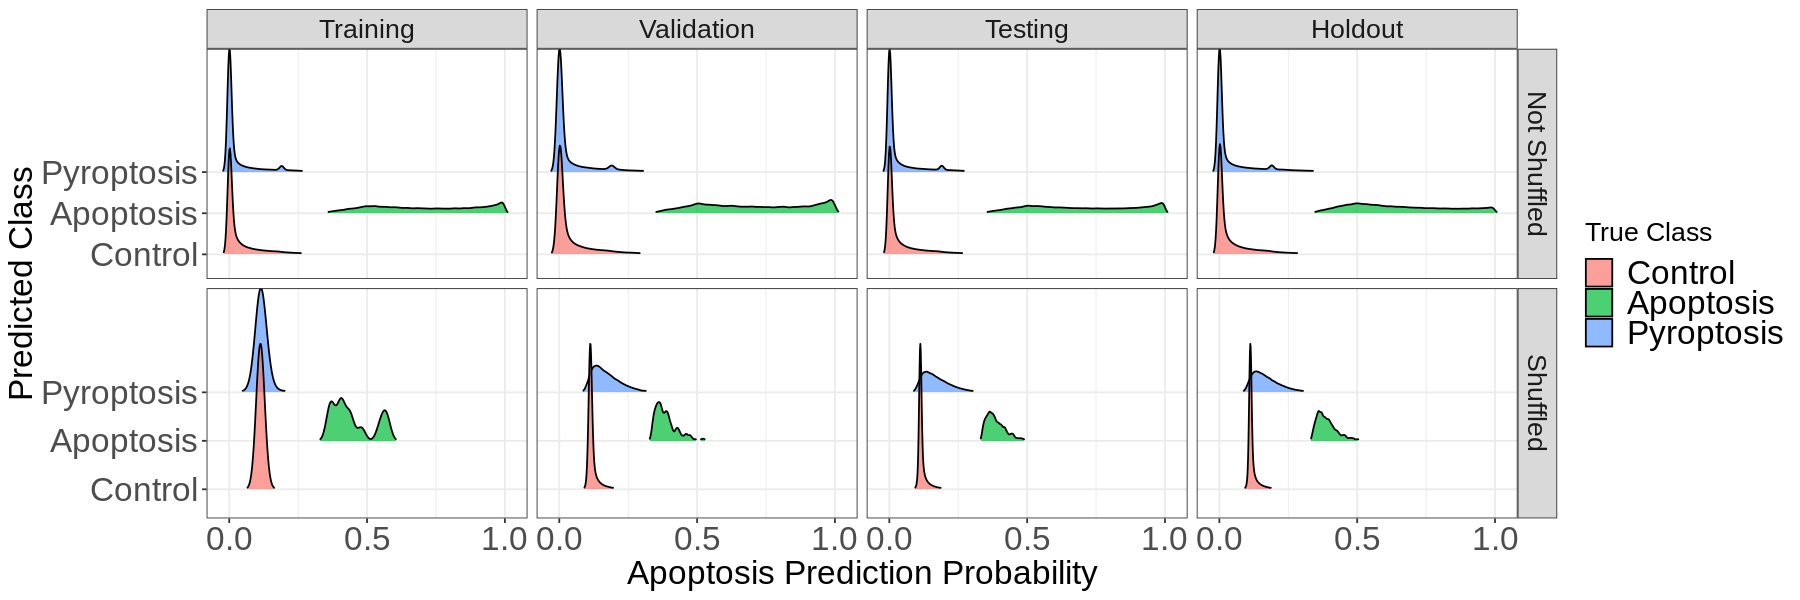

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Picking joint bandwidth of 0.0112

Picking joint bandwidth of 0.0148

Picking joint bandwidth of 0.0106

Picking joint bandwidth of 0.011

Picking joint bandwidth of 0.00805

Picking joint bandwidth of 0.0041

Picking joint bandwidth of 0.00312

Picking joint bandwidth of 0.00313



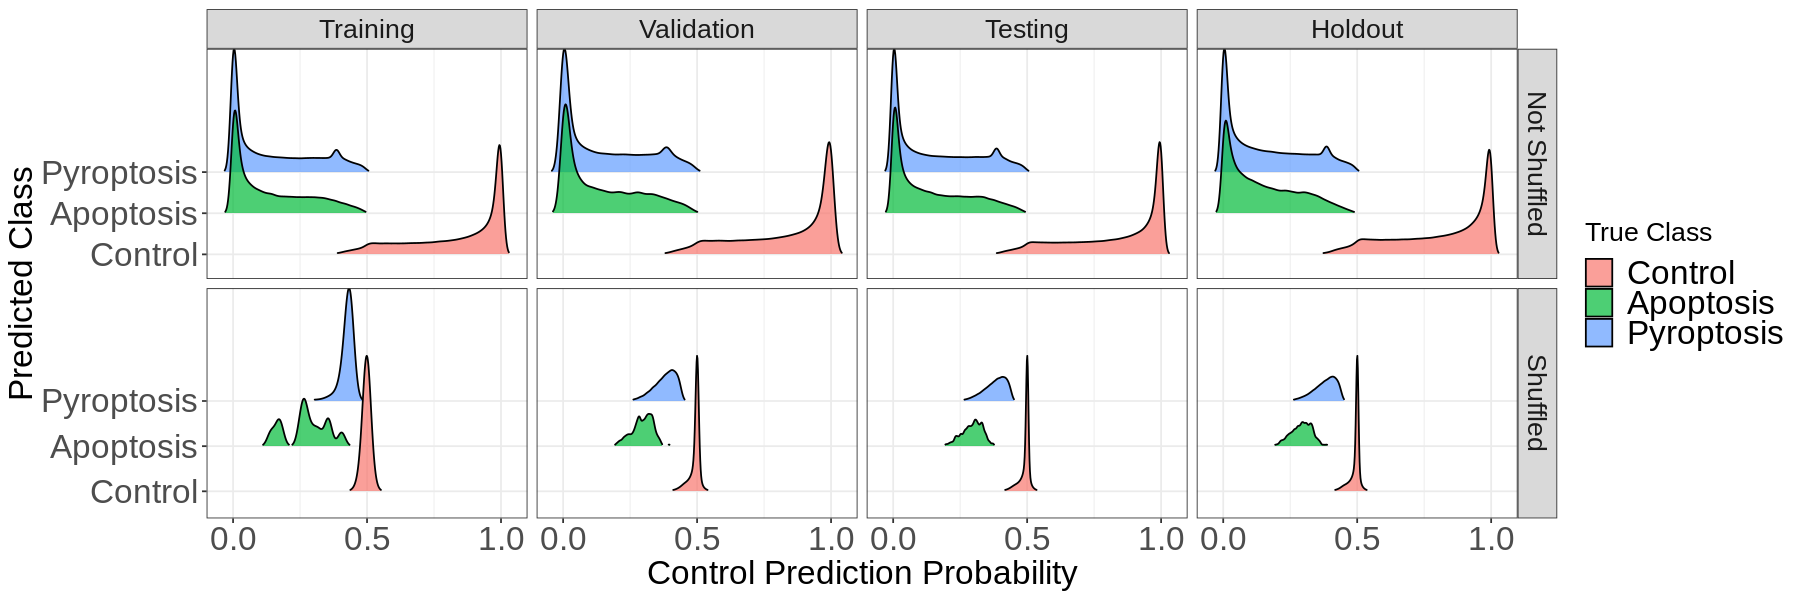

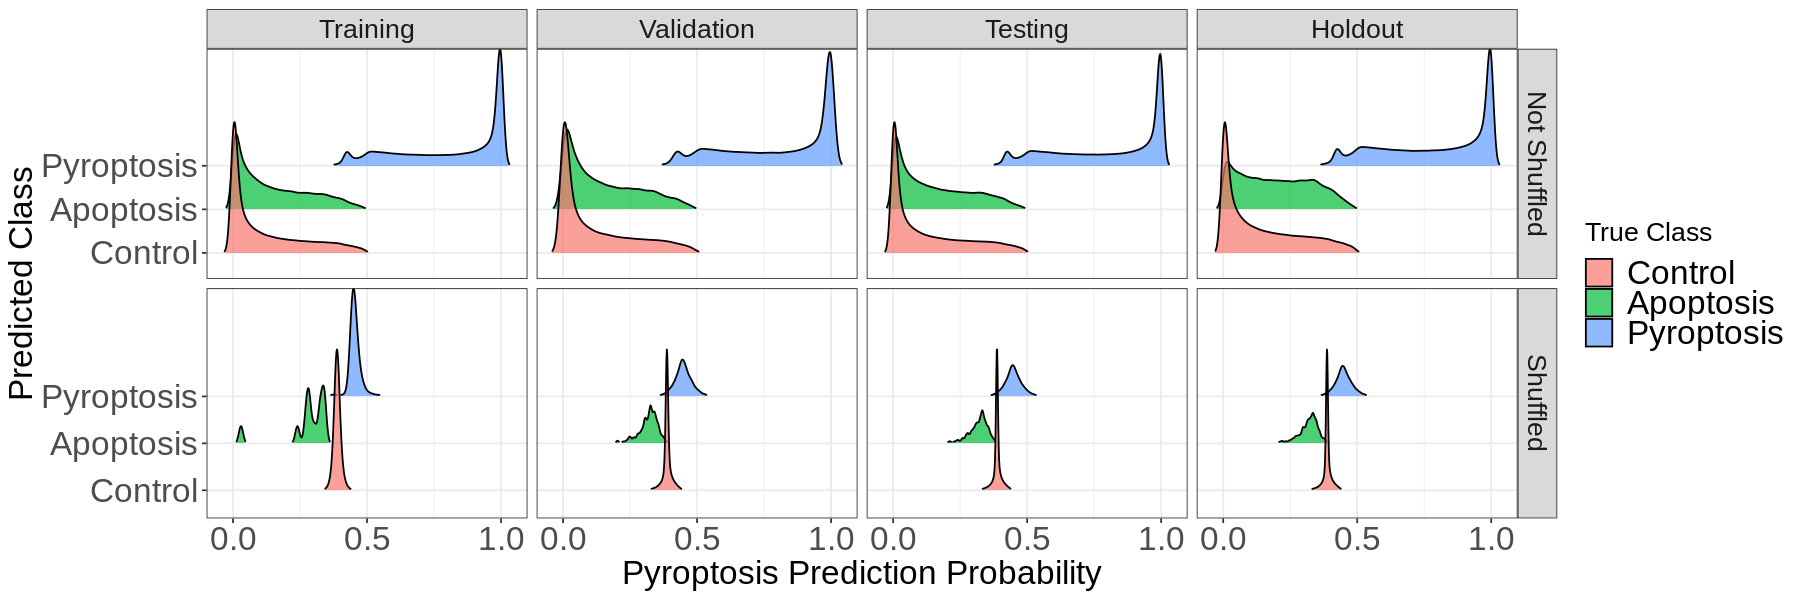

In [20]:
height <- 5
width <- 15
options(repr.plot.width = width, repr.plot.height = height)
ridge_plot_apoptosis <- (
    ggplot(probabilities, aes(x = apoptosis_prob, y = label_pred, fill = label_true, group = label_pred))
    + geom_density_ridges(
        aes(fill = label_pred), alpha = 0.7, scale = 3, rel_min_height = 0.01
    )
    + facet_grid(shuffle~data_split, scales = "free_y")
    + scale_x_continuous(breaks = seq(0, 1, 0.5))
    + labs(x = "Apoptosis Prediction Probability", y = "Predicted Class",fill = "True Class")
    + labs()
    + theme_bw()
    + figure_theme
)
ridge_plot_apoptosis

ridge_plot_control <- (
    ggplot(probabilities, aes(x = control_prob, y = label_pred, fill = label_true, group = label_pred))
    + geom_density_ridges(
        aes(fill = label_pred), alpha = 0.7, scale = 3, rel_min_height = 0.01
    )
    + facet_grid(shuffle~data_split, scales = "free_y")
    + scale_x_continuous(breaks = seq(0, 1, 0.5))
    + labs(x = "Control Prediction Probability", y = "Predicted Class",fill = "True Class")
    + labs()
    + theme_bw()
    + figure_theme
)
ridge_plot_control

ridge_plot_pyroptosis <- (
    ggplot(probabilities, aes(x = pyroptosis_prob, y = label_pred, fill = label_true, group = label_pred))
    + geom_density_ridges(
        aes(fill = label_pred), alpha = 0.7, scale = 3, rel_min_height = 0.01
    )
    + facet_grid(shuffle~data_split, scales = "free_y")+ scale_x_continuous(breaks = seq(0, 1, 0.5))
    + scale_x_continuous(breaks = seq(0, 1, 0.5))
    + labs(x = "Pyroptosis Prediction Probability", y = "Predicted Class",fill = "True Class")
    + labs()
    + theme_bw()
    + figure_theme
)
ridge_plot_pyroptosis

### Patch the individual facet grids together for a figure sub-panel

Picking joint bandwidth of 0.00735

Picking joint bandwidth of 0.00974

Picking joint bandwidth of 0.0071

Picking joint bandwidth of 0.00745

Picking joint bandwidth of 0.0147

Picking joint bandwidth of 0.00562

Picking joint bandwidth of 0.00397

Picking joint bandwidth of 0.00401

Picking joint bandwidth of 0.0112

Picking joint bandwidth of 0.0148

Picking joint bandwidth of 0.0106

Picking joint bandwidth of 0.0106

Picking joint bandwidth of 0.0139

Picking joint bandwidth of 0.0056

Picking joint bandwidth of 0.00405

Picking joint bandwidth of 0.00408

Picking joint bandwidth of 0.0112

Picking joint bandwidth of 0.0148

Picking joint bandwidth of 0.0106

Picking joint bandwidth of 0.011

Picking joint bandwidth of 0.00805

Picking joint bandwidth of 0.0041

Picking joint bandwidth of 0.00312

Picking joint bandwidth of 0.00313



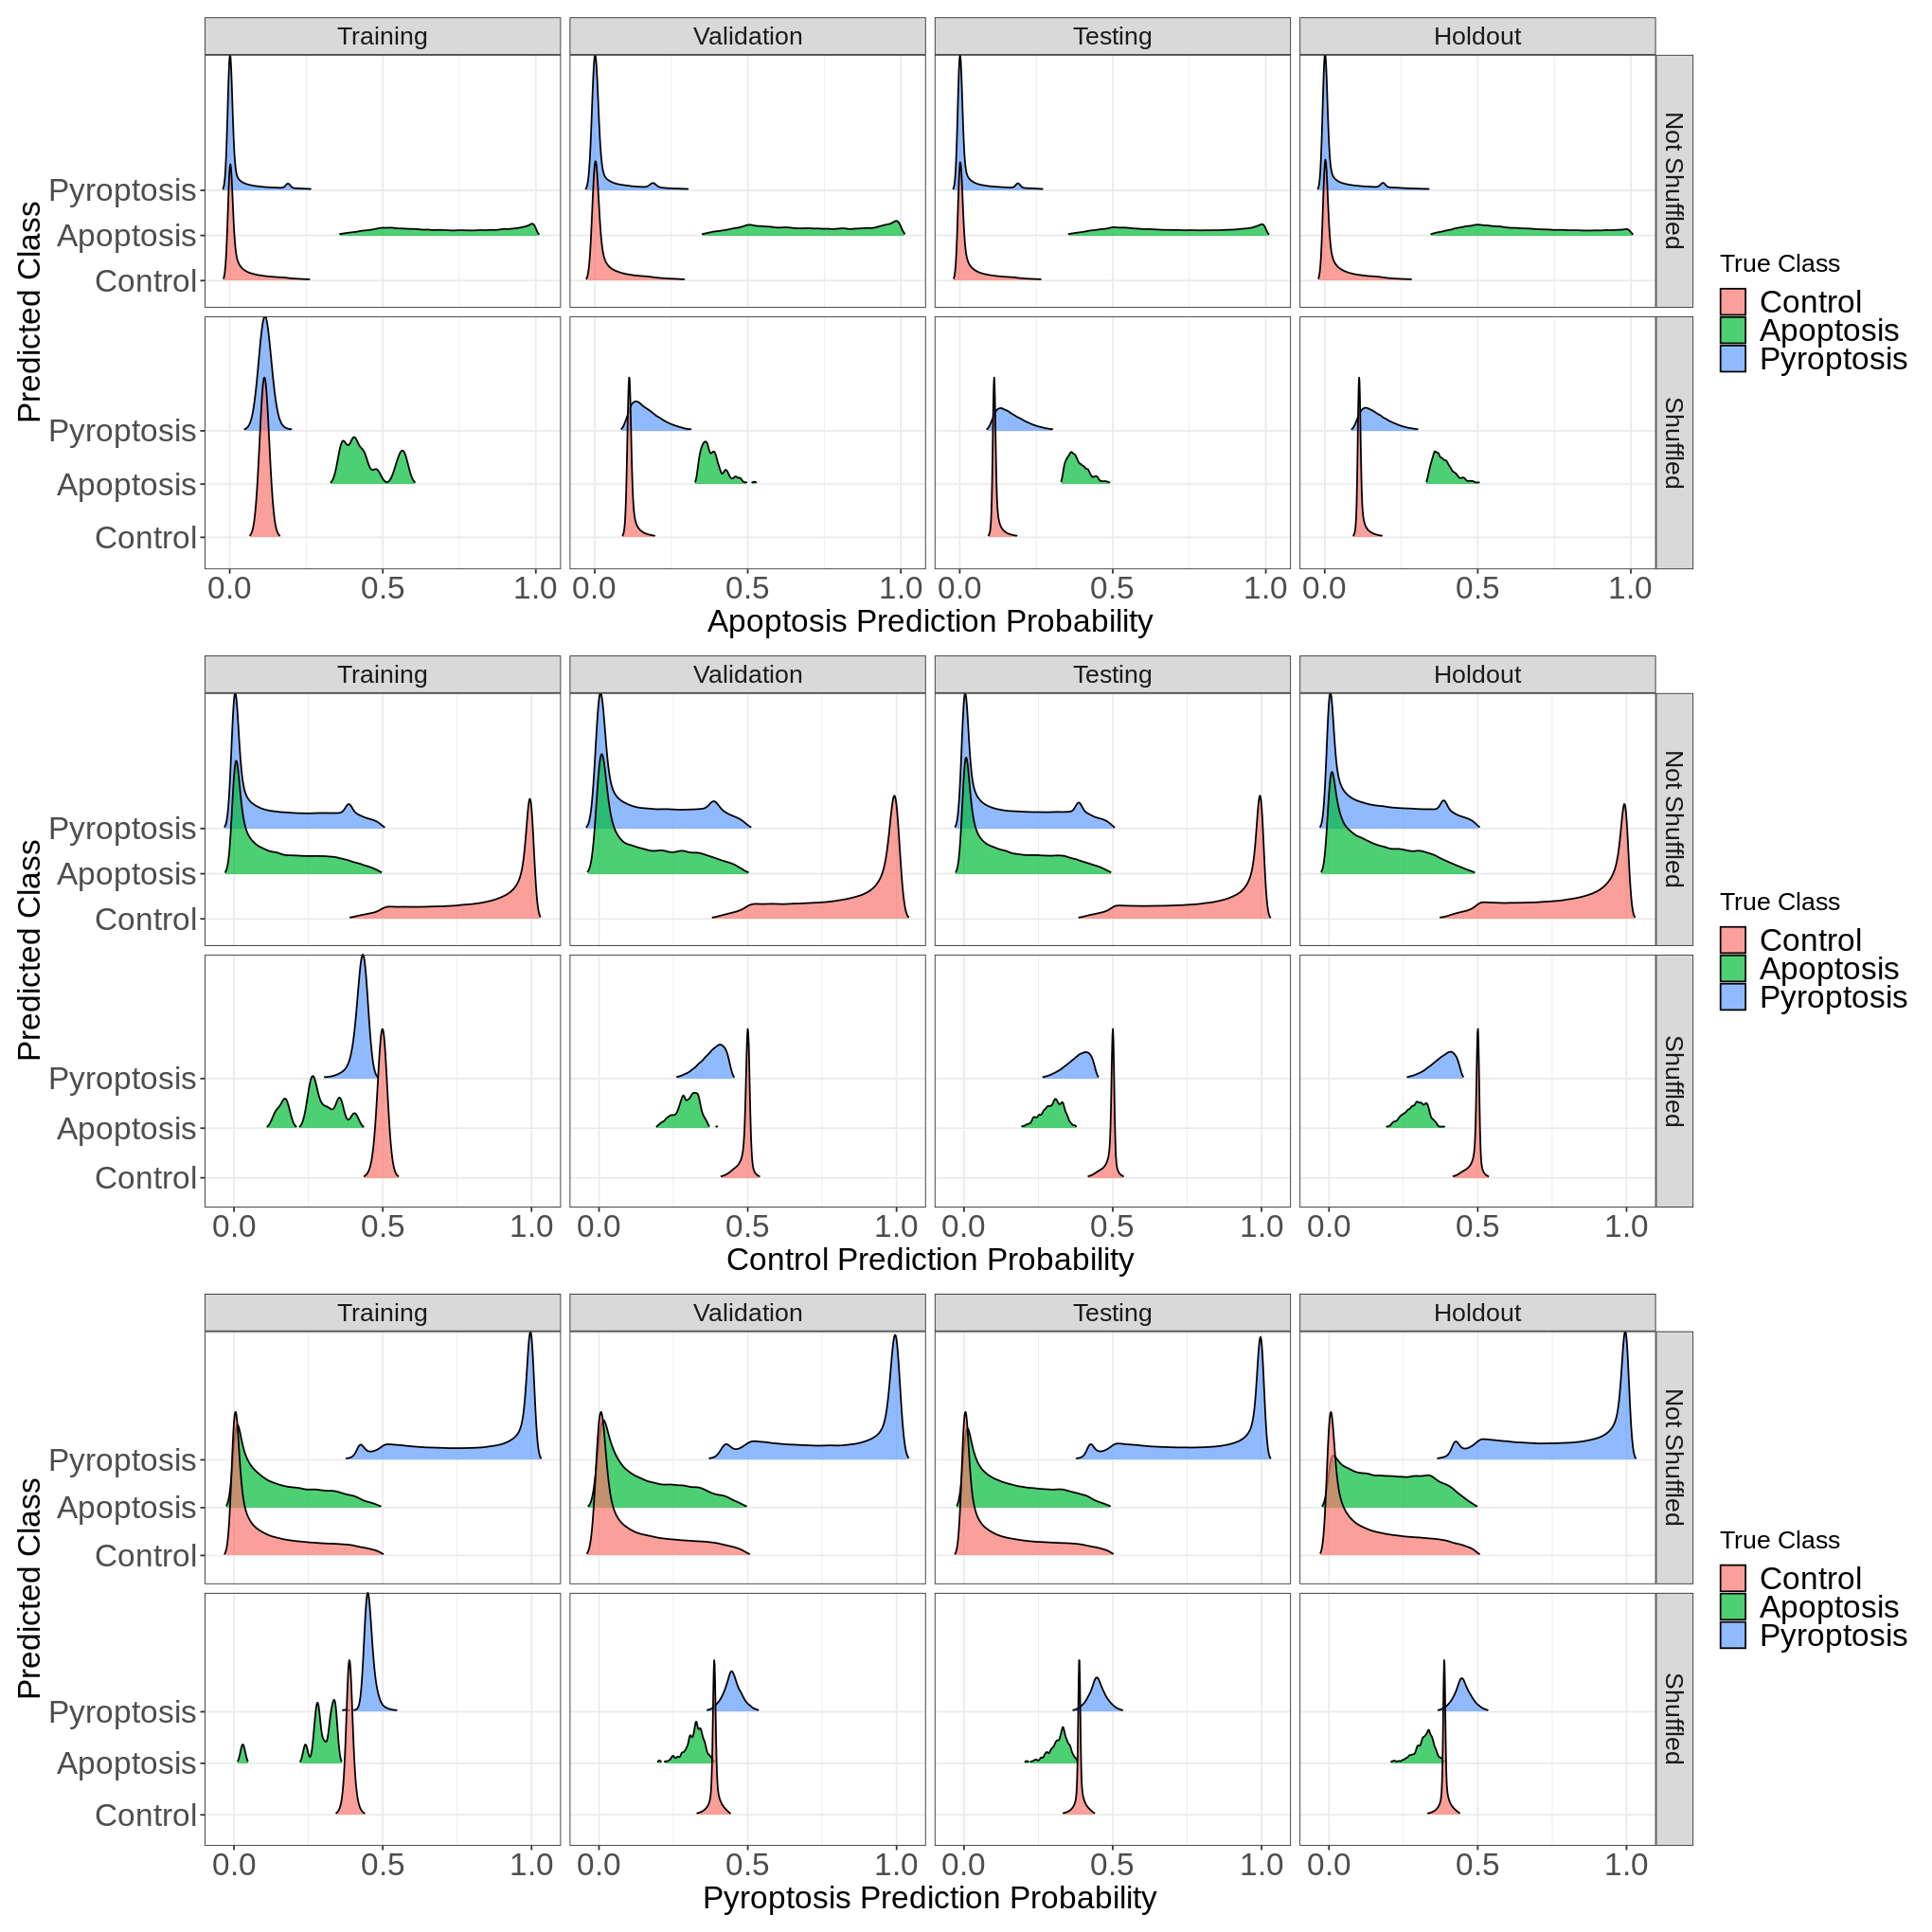

In [21]:
# ridge_plot_apoptosis
# ridge_plot_control
# ridge_plot_pyroptosis
# patch the plots together via the patchwork package
layout <- c(
    area(t=1, b=2, l=1, r=1), # A
    area(t=3, b=4, l=1, r=1), # B
    area(t=5, b=6, l=1, r=1)  # C
)
# set plot size
width <- 17
height <- 17
options(repr.plot.width=width, repr.plot.height=height, units = "cm", dpi = 600)
fig5_probabilities <- (
    ridge_plot_apoptosis
    + ridge_plot_control
    + ridge_plot_pyroptosis
    + plot_layout(design = layout)
)
fig5_probabilities

## single cell predictions 

In [22]:
sc_preds_path <- file.path(
    paste0(
        "../../8.cytopick_analysis/results/PBMC/single_cell_predictions.parquet"
    )
)
# read in the data from the parquet file
sc_preds <- arrow::read_parquet(
    sc_preds_path
)
head(sc_preds,2)
# get the rows that are pyroptosis and correct = true and shuffle = false
pyroptosis_correct_holdout <- sc_preds[
    sc_preds$labels == "pyroptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "holdout",]
# get the first row 
pyroptosis_correct_holdout$image_crop_path[1]


ERROR: Error: IOError: Failed to open local file '../../8.cytopick_analysis/results/PBMC/single_cell_predictions.parquet'. Detail: [errno 2] No such file or directory


In [ ]:
unique(sc_preds$labels)
unique(sc_preds$data_split)

In [ ]:
# define df subsets for each class, data split
pyroptosis_correct_train <- sc_preds[
    sc_preds$labels == "pyroptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "train",]
pyroptosis_correct_validation <- sc_preds[
    sc_preds$labels == "pyroptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "validation",]
pyroptosis_correct_test <- sc_preds[
    sc_preds$labels == "pyroptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "testing",]
pyroptosis_correct_holdout <- sc_preds[
    sc_preds$labels == "pyroptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "holdout",]
pyroptosis_correct_treatment_holdout <- sc_preds[
    sc_preds$labels == "pyroptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "treatment_holdout",]

# repeat for apoptosis
apoptosis_correct_train <- sc_preds[
    sc_preds$labels == "apoptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "train",]
apoptosis_correct_validation <- sc_preds[
    sc_preds$labels == "apoptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "validation",]
apoptosis_correct_test <- sc_preds[
    sc_preds$labels == "apoptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "testing",]
apoptosis_correct_holdout <- sc_preds[
    sc_preds$labels == "apoptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "holdout",]

# repeat for control
control_correct_train <- sc_preds[
    sc_preds$labels == "healthy" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "train",]
control_correct_validation <- sc_preds[
    sc_preds$labels == "healthy" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "validation",]
control_correct_test <- sc_preds[
    sc_preds$labels == "healthy" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "testing",]
control_correct_holdout <- sc_preds[
    sc_preds$labels == "healthy" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "holdout",]


# make a list of the data frames for each class
correct_class_dfs <- list(
    pyroptosis_correct_train,
    pyroptosis_correct_validation,
    pyroptosis_correct_test,
    pyroptosis_correct_holdout,
    pyroptosis_correct_treatment_holdout,

    apoptosis_correct_train,
    apoptosis_correct_validation,
    apoptosis_correct_test,
    apoptosis_correct_holdout,
    
    control_correct_train,
    control_correct_validation,
    control_correct_test,
    control_correct_holdout
)



In [ ]:
width <- 2
height <- 2
options(repr.plot.width = width, repr.plot.height = height)
# define function to return the image object
get_image <- function(df){
    # Load the PNG file
    img <- png::readPNG(df$image_crop_path[4])
    # Convert the image to a raster object
    g <- grid::rasterGrob(img, interpolate=TRUE)

    # Create a ggplot
    p <- ggplot() +
    annotation_custom(g, xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf) +
    theme_void()  # Remove axes and labels

    # Print the plot
    return(p)
}


In [ ]:
pyroptosis_correct_holdout_image <- get_image(pyroptosis_correct_holdout)
pyroptosis_correct_test_image <- get_image(pyroptosis_correct_test)
control_correct_holdout_image <- get_image(control_correct_holdout)
control_correct_test_image <- get_image(control_correct_test)
apoptosis_correct_holdout_image <- get_image(apoptosis_correct_holdout)
apoptosis_correct_test_image <- get_image(apoptosis_correct_test)

# add titles to each image
pyroptosis_correct_holdout_image <- (
    pyroptosis_correct_holdout_image 
    + ggtitle("Pyroptosis (Holdout)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
)
pyroptosis_correct_test_image <- (
    pyroptosis_correct_test_image 
    + ggtitle("Pyroptosis (Test)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
)
control_correct_holdout_image <- (
    control_correct_holdout_image 
    + ggtitle("Control (Holdout)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
)
control_correct_test_image <- (
    control_correct_test_image 
    + ggtitle("Control (Test)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
)
apoptosis_correct_holdout_image <- (
    apoptosis_correct_holdout_image 
    + ggtitle("Apoptosis (Holdout)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
)
apoptosis_correct_test_image <- (
    apoptosis_correct_test_image 
    + ggtitle("Apoptosis (Test)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
)



In [ ]:
width <- 6
height <- 5
options(repr.plot.width = width, repr.plot.height = height)
# stich the images together
correct_class_images <- (
    # plot image with 
    wrap_elements(full = control_correct_test_image)
    + wrap_elements(full = apoptosis_correct_test_image)
    + wrap_elements(full = pyroptosis_correct_test_image)
    + wrap_elements(full = control_correct_holdout_image)
    + wrap_elements(full = apoptosis_correct_holdout_image)
    + wrap_elements(full = pyroptosis_correct_holdout_image)
    
    # + plot_layout(nrow = 2,widths = c(1,1,1), heights = c(1,1))
)
correct_class_images
# save the image
ggsave(
    file.path(
        paste0(
            "figures/Multi_Class/",model_name,"/",cell_type,"/correct_class_images.png"
        )
    ),
    correct_class_images, width = width, height = height, dpi = 600
)

### Patch the plots together

In [ ]:
layout <- c(
    area(t=1, b=2, l=1, r=2), # A
    area(t=1, b=2, l=3, r=4), # B
    area(t=3, b=4, l=1, r=4), # C
)
# set plot size
width <- 17
height <- 17
options(repr.plot.width=width, repr.plot.height=height, units = "cm", dpi = 600)
fig5 <- (
    wrap_elements(full = confusion_matrix_plot)
    + wrap_elements(full = pr_plot)
    + wrap_elements(full = correct_class_images)
    
    
    # + fig5_probabilities
    + plot_layout(design = layout, widths = c(10, 10))
    # make bottom plot not align
    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 20))
)
fig5

# save the plot
ggsave("figures/figure5.png", fig5, width = width, height = height, dpi = 600)
